In [1]:
import pandas as pd
import os
import shutil
import cv2
from multiprocessing import Pool
import time
import process_images_448_448
import process_images_128_128
import gc
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
import PIL
from PIL import Image
import imageio
import logging as log
import tarfile
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(128,128,3),
                                               include_top=False,
                                               weights=None)
ResNet50_MODEL.trainable=True

In [4]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(512, activation='relu'),
                                  tf.keras.layers.Dense(92740, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 92740)             47575620  
Total params: 72,212,420
Trainable params: 72,159,300
Non-trainable params: 53,120
_______________________________________

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#flow training images in batches of 128
train_generator = train_datagen.flow_from_directory(
    'datasets/set_128/train/',
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical'
)
history = model.fit_generator(
    train_generator,
    epochs = 5,
    verbose=1
)

Found 3064239 images belonging to 92740 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 11970 steps
Epoch 1/5
11970/11970 [==============================] - 8119s 678ms/step - loss: 11.0944 - accuracy: 1.1748e-04
Epoch 2/5
11970/11970 [==============================] - 7873s 658ms/step - loss: 10.4670 - accuracy: 0.0011
Epoch 3/5
11970/11970 [==============================] - 7875s 658ms/step - loss: 9.7026 - accuracy: 0.0052
Epoch 4/5
11970/11970 [==============================] - 7874s 658ms/step - loss: 9.1130 - accuracy: 0.0117
Epoch 5/5
11970/11970 [==============================] - 7819s 653ms/step - loss: 8.6160 - accuracy: 0.0214


<Figure size 432x288 with 0 Axes>

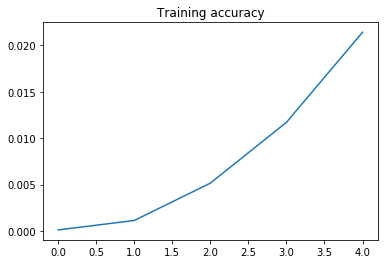

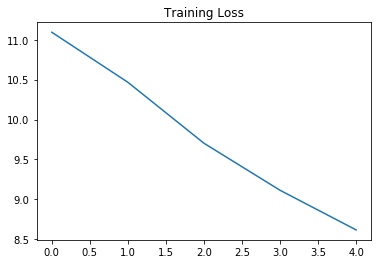

<Figure size 432x288 with 0 Axes>

In [8]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.title('Training Loss')
plt.figure()